In [84]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [85]:
import fuel
from fuel.datasets import MNIST
import theano
from theano import tensor as T
import blocks
import blocks.bricks
from blocks.bricks import Linear, Rectifier, Softmax
from blocks.bricks.cost import CategoricalCrossEntropy
from blocks.bricks.cost import MisclassificationRate
#
from blocks.roles import WEIGHT
from blocks.graph import ComputationGraph
from blocks.filter import VariableFilter
#
from blocks.initialization import IsotropicGaussian, Constant
#
from blocks.model import Model

In [86]:
x=T.matrix('features')
input_to_output=Linear(name='input_to_output', input_dim=784, output_dim=10)
h=Rectifier().apply(input_to_output.apply(x))
y_hat=Softmax().apply(h)
#
y=T.lmatrix('targets')
cost=CategoricalCrossEntropy().apply(y.flatten(), y_hat)
error_rate = MisclassificationRate().apply(y.flatten(), y_hat)
#
cg=ComputationGraph(cost)
W1=VariableFilter(roles=[WEIGHT])(cg.variables)[0]
cost = cost + 0.005 * (W1 ** 2).sum()
cost.name = 'cost_with_regularization'
#
input_to_output.weights_init = IsotropicGaussian(0.01)
input_to_output.biases_init = Constant(0)
input_to_output.initialize()
#
from fuel.datasets import MNIST
from fuel.streams import DataStream
from fuel.schemes import SequentialScheme
from fuel.transformers import Flatten
mnist=MNIST(('train',))
data_stream = Flatten(DataStream.default_stream(
        mnist,
        iteration_scheme=SequentialScheme(mnist.num_examples, batch_size=256)))
#
mnist_test = MNIST(("test",))
data_stream_test = Flatten(DataStream.default_stream(
        mnist_test,
        iteration_scheme=SequentialScheme(mnist_test.num_examples, batch_size=1024)))
#
from blocks.algorithms import GradientDescent, Scale
algorithm = GradientDescent(cost=cost, parameters=cg.parameters,
                            step_rule=Scale(learning_rate=0.1))
#
from blocks.extensions.monitoring import DataStreamMonitoring
monitor = DataStreamMonitoring(
    variables=[cost, error_rate], data_stream=data_stream_test, prefix="test-FUCK")
#
from blocks.main_loop import MainLoop
from blocks.extensions import FinishAfter, Printing
main_loop = MainLoop(data_stream=data_stream, algorithm=algorithm,
                     model=Model(error_rate),
                     extensions=[monitor, FinishAfter(after_n_epochs=30), Printing()])
main_loop.run()


-------------------------------------------------------------------------------
BEFORE FIRST EPOCH
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 0
	 received_first_batch: False
	 resumed_from: None
	 training_started: True
Log records from the iteration 0:
	 test-FUCK_cost_with_regularization: 2.3140829862
	 test-FUCK_misclassificationrate_apply_error_rate: 0.927883848852


-------------------------------------------------------------------------------
AFTER ANOTHER EPOCH
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: False
	 epochs_done: 1
	 iterations_done: 235
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 235:
	 test

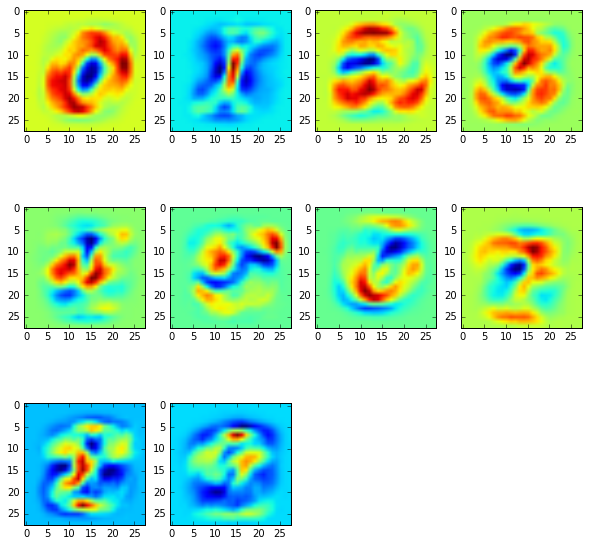

In [87]:
numx=4
numW=10
numy=numW/numx
if numx*numy<numW:
    numy+=1
plt.figure(figsize=(10,10))
for xx in xrange(numx):
    for yy in xrange(numy):
        pos=yy*numx+xx
        if pos<numW:
            plt.subplot(numy,numx,pos+1)
            plt.imshow(input_to_output.W.eval()[:,pos].reshape(28,28))
            